In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A

# pretrained models
import torchvision
from torchvision import models, transforms

Image Data from [here](https://www.kaggle.com/andrewmvd/animal-faces)
- Animal Faces

## Resizing

In [2]:
# create a dataframe for our image data
data_path = 'course_data/afhq'

rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            rows.append(row)
        
df = pd.DataFrame(rows)
print(len(df))
df.head()

16130


,image_file,label,dataset,image_path
0,pixabay_cat_000455.jpg,cat,train,course_data/afhq/train/cat
1,pixabay_cat_001993.jpg,cat,train,course_data/afhq/train/cat
2,pixabay_cat_004633.jpg,cat,train,course_data/afhq/train/cat
3,pixabay_cat_002242.jpg,cat,train,course_data/afhq/train/cat
4,pixabay_cat_002524.jpg,cat,train,course_data/afhq/train/cat


In [3]:
# training and validation data
df_train = df[df['dataset'] == 'train'].reset_index(drop=True)
df_val = df[df['dataset'] == 'val'].reset_index(drop=True)
len(df_train), len(df_val)

(14630, 1500)

We're going to work with a pre-trained model that takes in images of size 224x224. We will reduce the resolution as a *pre-processings* step rather than on the fly to save time during training.
- Notice the time we save during each epoch: 3 seconds for me

In [8]:
def resize_img(path, size):
    img = cv2.imread(path)
    
    start = time.time()
    img = cv2.resize(img, size)
    end = time.time()
    
    cv2.imwrite(path, img)
    return end - start

# resize all of the images to 256x256
total_time_resize = 0.0
for idx in tqdm(range(len(df_train))):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))
    
for idx in tqdm(range(len(df_val))):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))
    

  0%|          | 0/14630 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [9]:
total_time_resize

2.273089647293091

In [10]:
row = df_train.iloc[100]
image_path = row['image_path']
fname = row['image_file']
path = image_path+'/'+fname
img = cv2.imread(path)

img.shape

(256, 256, 3)

## Data Augmentation with [Albumentations](https://github.com/albumentations-team/albumentations)
- A suite of very fast transformations for images
- Supports masks and keypoints!

In [109]:
from albumentations.pytorch import ToTensorV2

# let's add an augmentation option
class AnimalFacesDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment
        
        # label dictionary
        self.label_dict = {'cat':0, 'dog':1, 'wild':2}
        
        # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5),
                
                # we will normalize according to ImageNet since we will be using a pre-trained ResNet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # training/valid images have same size
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        fname = row['image_file']
        path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # transform the image
        # certain transformations expect the uint8 datatype
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [162]:
ds_train = AnimalFacesDataset(df_train, augment=True)
dl_train = DataLoader(ds_train, batch_size = 16, shuffle=True)

ds_val = AnimalFacesDataset(df_val)
dl_val = DataLoader(ds_val, batch_size = 16, shuffle=True)

Below we double check that this is working properly, and can see the transformation in practice

torch.Size([3, 224, 224])
tensor(0)


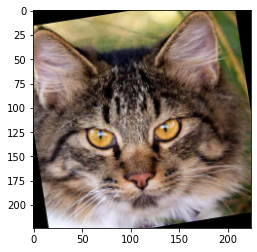

In [163]:
img, label = next(iter(ds_train))
print(img.shape)

# restructure for plt
img = np.transpose(np.array(img), (1,2,0))

# reverse the normalization
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
for i in range(3):
    img[:,:,i] = (img[:,:,i] * std[i]) + mean[i]

plt.imshow(img)
print(label)

## Pretrained Models
- Freezing Layers (feature extraction)
- Finetuning (weight initialization)

In [203]:
# drum roll...the pretrained resnet!
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/mruddy/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [204]:
# we can see the architecture
# note how many of the layers are organized in "BasicBlock"
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- Notice how the image eventually becomes a 1D vector of dimension 512
- In some sense the network has transformed an image into a vector of features helpful for image classification
- The last layer is a simple function (linear followed by softmax) on this feature space that predicts an images class
- One strategy is to train a new simple function on this **same** feature space for our classification task

In [205]:
from torchsummary import summary
summary(resnet, input_size = (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [206]:
# turn off gradients for all the parameters
for param in resnet.parameters():
            param.requires_grad = False

In [207]:
# re-intialize the last layer for our task
print(resnet.fc)
resnet.fc = nn.Linear(512, 3)
print(resnet.fc)

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=3, bias=True)


In [208]:
# re-initializing the layer reset to default settings
for param in resnet.fc.parameters():
    print(param.requires_grad)

True
True


In [209]:
# double-check all the parameters
for name, param in resnet.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

conv1.weight gradient is set to False
bn1.weight gradient is set to False
bn1.bias gradient is set to False
layer1.0.conv1.weight gradient is set to False
layer1.0.bn1.weight gradient is set to False
layer1.0.bn1.bias gradient is set to False
layer1.0.conv2.weight gradient is set to False
layer1.0.bn2.weight gradient is set to False
layer1.0.bn2.bias gradient is set to False
layer1.1.conv1.weight gradient is set to False
layer1.1.bn1.weight gradient is set to False
layer1.1.bn1.bias gradient is set to False
layer1.1.conv2.weight gradient is set to False
layer1.1.bn2.weight gradient is set to False
layer1.1.bn2.bias gradient is set to False
layer2.0.conv1.weight gradient is set to False
layer2.0.bn1.weight gradient is set to False
layer2.0.bn1.bias gradient is set to False
layer2.0.conv2.weight gradient is set to False
layer2.0.bn2.weight gradient is set to False
layer2.0.bn2.bias gradient is set to False
layer2.0.downsample.0.weight gradient is set to False
layer2.0.downsample.1.weight

In [210]:
# pass the appropriate parameters to the optimizer
params_to_update = []

for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

In [211]:
# let's make sure that this actually freezes/trains the layers, take a sample weight
print(resnet.conv1.weight[0])
print(resnet.fc.bias)

tensor([[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  7.4841e-02,  5.6615e-02,
           1.7083e-02, -1.2694e-02],
         [ 1.1083e-02,  9.5276e-03, -1.0993e-01, -2.8050e-01, -2.7124e-01,
          -1.2907e-01,  3.7424e-03],
         [-6.9434e-03,  5.9089e-02,  2.9548e-01,  5.8720e-01,  5.1972e-01,
           2.5632e-01,  6.3573e-02],
         [ 3.0505e-02, -6.7018e-02, -2.9841e-01, -4.3868e-01, -2.7085e-01,
          -6.1282e-04,  5.7602e-02],
         [-2.7535e-02,  1.6045e-02,  7.2595e-02, -5.4102e-02, -3.3285e-01,
          -4.2058e-01, -2.5781e-01],
         [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  2.3897e-01,  4.1384e-01,
           3.9359e-01,  1.6606e-01],
         [-1.3736e-02, -3.6746e-03, -2.4084e-02, -6.5877e-02, -1.5070e-01,
          -8.2230e-02, -5.7828e-03]],

        [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  3.6812e-02,  3.2521e-02,
           6.6221e-04, -2.5743e-02],
         [ 4.5687e-02,  3.3603e-02, -1.0453e-01, -3.0885e-01, -3.1253e-01,
          -1.6051e-01, -1.2

In [212]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [213]:
from tqdm.notebook import tqdm

lossFun = nn.CrossEntropyLoss()

num_epochs = 5
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(resnet, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(resnet, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(resnet, dl_train, len(ds_train))
    valid_acc = one_pass_acc(resnet, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/915 [00:00<?, ?it/s]

KeyboardInterrupt: 

Note how long it takes to train for images

In [214]:
print(resnet.conv1.weight[0])
print(resnet.fc.bias)

tensor([[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  7.4841e-02,  5.6615e-02,
           1.7083e-02, -1.2694e-02],
         [ 1.1083e-02,  9.5276e-03, -1.0993e-01, -2.8050e-01, -2.7124e-01,
          -1.2907e-01,  3.7424e-03],
         [-6.9434e-03,  5.9089e-02,  2.9548e-01,  5.8720e-01,  5.1972e-01,
           2.5632e-01,  6.3573e-02],
         [ 3.0505e-02, -6.7018e-02, -2.9841e-01, -4.3868e-01, -2.7085e-01,
          -6.1282e-04,  5.7602e-02],
         [-2.7535e-02,  1.6045e-02,  7.2595e-02, -5.4102e-02, -3.3285e-01,
          -4.2058e-01, -2.5781e-01],
         [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  2.3897e-01,  4.1384e-01,
           3.9359e-01,  1.6606e-01],
         [-1.3736e-02, -3.6746e-03, -2.4084e-02, -6.5877e-02, -1.5070e-01,
          -8.2230e-02, -5.7828e-03]],

        [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  3.6812e-02,  3.2521e-02,
           6.6221e-04, -2.5743e-02],
         [ 4.5687e-02,  3.3603e-02, -1.0453e-01, -3.0885e-01, -3.1253e-01,
          -1.6051e-01, -1.2

If we want to finetune, we can either
- use the resnet as a starting point and train by treating the pretrained weights as good weight initilaization OR
- we can train different layers at different learning rates (the later the layer, the more we want to adjust the feature)

In [215]:
# we can pass the optimizer groups of parameters rather than all the parameters in one group
for param_group in optimizer.param_groups:
    print(param_group)

{'params': [Parameter containing:
tensor([[-0.0206,  0.0087, -0.0246,  ...,  0.0098,  0.0345,  0.0070],
        [-0.0025, -0.0248, -0.0280,  ..., -0.0303, -0.0029,  0.0282],
        [ 0.0254, -0.0322, -0.0137,  ..., -0.0400,  0.0120,  0.0325]],
       requires_grad=True), Parameter containing:
tensor([0.0296, 0.0345, 0.0350], requires_grad=True)], 'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}


In [216]:
for name, layer in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [217]:
max_lr = 0.01
params = []
for i, layer in enumerate(resnet.children()):
    if i < 6:
        params.append({'params': layer.parameters(), 'lr': max_lr / 100})
    elif 5 < i < 9:
        params.append({'params': layer.parameters(), 'lr': max_lr / 10})
    else:
        params.append({'params': layer.parameters()})
        
# only the parameters we didn't manually set the learning rate for inherit the learning rate set when defining the optimizer
optimizer = optim.Adam(params, lr = max_lr)

In [218]:
# we can see the parameters groups here
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 3
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 4
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 5
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 6
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 7
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 8
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weigh

In [220]:
# to make this a bit cleaner you can make a new model class
# use model.features1, model.features2, and model.classifier to set the learning rates
class Tune_ResNet(nn.Module):
    def __init__(self):
        super(Tune_ResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:9]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Linear(512, 3)
        self.unroll = nn.Flatten()
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.unroll(x)
        x = self.classifier(x)
        return x
    
model = Tune_ResNet()
summary(model, input_size = (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Training on a GPU
- We saw how slow it was to train images on a cpu
- PyTorch makes it easy to do this training on a GPU!
- Always follow GPU etiquette and check who is running what

In [222]:
# is a GPU available?
torch.cuda.is_available()

False

In [221]:
# check who is using what
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [223]:
# how many devices are there?
torch.cuda.device_count()

0

In [225]:
device_no = 0
if torch.cuda.is_available() == True:
    device = torch.device(device_no)
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [226]:
# move model parameters to device
model.to(device)

Tune_ResNet(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
# let's adapt our earlier function
def one_pass(model, dataloader, optimizer, lossFun, device, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        # send labelled data to the device
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

Note that
- The model can only take inputs on the same device
- The output is also on the specified device and cannot interact with tensors on a different device

In [227]:
x, y = next(iter(dl_train))

# move to device
x, y = x.to(device), y.to(device)

# perform computation
y_pred = model(x)

# now its on the cpu again
y_pred.cpu()